In [1]:
import delegator

In [2]:
# The first thing as in any problem is we have to get data
# I used kenpom
# I wasn't able to get through the auth with requests -- so I shell drop into curl commands
# I got the curl commands from Chrome Developer tools while loading the webpage

In [8]:
def get_html(url, cookie):
    try:
        template = "curl '{url}' -H 'pragma: no-cache' -H 'cookie: PHPSESSID={cookie}' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'cache-control: no-cache' -H 'authority: kenpom.com' -H 'referer: https://kenpom.com/opptracker.php?team=Virginia' --compressed"
        cmd = template.format(url=url, cookie=cookie)
        c = delegator.run(cmd)
        c.block()
        content = c.out
        return content
    except Exception as e:
        print(e)
        return None
cookie='qmvu4bd3snvqb80hq6cjc6lls4'
#get_html(url='https://kenpom.com/team.php?team=Virginia&y=2017', cookie=cookie)

In [4]:
import requests
index_page = requests.get('https://kenpom.com/').content

In [5]:
import re
import time

In [6]:
all_teams = re.findall('team.php.team=.*?"', str(index_page))[:-1]
all_teams = [x[:-1] for x in all_teams] # remove the " at the end I matched

In [7]:
import os
if not os.path.exists('raw_data'):
    os.mkdir('raw_data')

In [16]:
# Get Data for Years

years = [2017, 2018, 2019, 2020]
#years = [2019]
#years = []
for my_team in all_teams:
    for year in years:
        team = "%s&y=%s" % (my_team, year)
        team_str = team[9:]
        team_name = team_str[5:]
        url = 'https://kenpom.com/%s' % team
        fname = 'raw_data/%s.html' % team_name
        if os.path.exists(fname):
            continue
        print(fname)
        html = get_html(url, cookie)
        with open(fname, 'w') as fout:
            fout.write(html)
        time.sleep(1)

In [17]:
import os
html_files = os.listdir('raw_data')

In [18]:
import os
import re
keywords = [
    'RankAdjOE',
    'RankAdjDE',
    'RankAdjTempo',
    'RankAPL_Off',
    'RankAPL_Def',
    'RankeFG_Pct',
    'RankDeFG_Pct',
    'RankTO_Pct',
    'RankDTO_Pct',
    'RankOR_Pct',
    'RankDOR_Pct',
    'RankFT_Rate',
    'RankDFT_Rate',
    'RankDFT_Rate',
    'RankFG3Pct',
    'RankFG3Pct.*&od=d',
    'RankFG2Pct',
    'RankFG2Pct.*&od=d',
    'RankFTPct',
    'RankFTPct.*&od=d',
    'RankBlockPct',
    'RankBlockPct.*&od=d',
    'RankStlRate',
    'RankStlRate.*&od=d',
    'RankF3GRate',
    'RankF3GRate.*&od=d',
    'RankARate',
    'RankARate.*&od=d',
    'RankOff_3',
    'RankDef_3',
    'RankOff_2',
    'RankDef_2',
    'RankOff_1',
    'RankDef_1',
    'RankSOSO',
    'RankSOSD',
    'ExpRank',
    'SizeRank',
]

def get_feature_vector(html_str, fname):
    fv = []
    for keyword in keywords:
        pattern = '%s.*>(\d+\.\d+)' % keyword
        val = re.findall(pattern, html_str)[-1]
        fv.append(float(val))
    year = re.findall(".*=(\d+).*", fname)[0]
    return fv + [float(year)]

def score_to_diff(s, neg=False):
    s = [float(x) for x in s.split('-')]
    v = abs(s[0] - s[1])
    if neg:
        return -1 * v
    return v

def get_wins_losses(html_str):
    pat = 'team.php.*?=(.*?)".*>W<.* (\d+-\d+).*\n'
    wins = re.findall(pat, html_str)
    wins = [(x[0], score_to_diff(x[1])) for x in wins]
    
    pat = 'team.php.*?=(.*?)".*>L<.* (\d+-\d+).*\n'
    losses = re.findall(pat, html_str)
    losses = [(x[0], score_to_diff(x[1], True)) for x in losses]
    # Only return wins and then data augment after doing splits
    return wins

def parse_html_file(html_str, fname):
    """
    return feature_vector, list of (oppenent, +- score)
    """
    fv = get_feature_vector(html_str, fname)
    wl = get_wins_losses(html_str)
    return fv, wl


In [19]:
html_files = os.listdir('raw_data')
d = {}
for html_file in html_files:
    html_str = open('raw_data/%s' % html_file).read()
    if len(html_str) == 0:
        continue
    team_name = html_file[:-5]
    d[team_name] = parse_html_file(html_str, html_file)

In [56]:
import json
with open("team_fvs.json", 'w') as fout:
    s = json.dumps(d, indent=4, sort_keys=True)
    fout.write(s)

In [21]:
from ligand_ml.data import DiskDataset 
import numpy as np

X = []
ys = []
for k, v in d.items():
    my_fv = v[0]
    oppenents = v[1]
    for opp in oppenents:
        if opp[0].find("&y") == -1:
            opp_name = opp[0] + "&y=2020"
            opp = (opp_name, opp[1])
        if opp[0] not in d:
            print(opp[0])
            continue
        their_fv = d[opp[0]][0]
        fv = my_fv + their_fv
        y = opp[1]
        X.append(fv)
        ys.append(y)
DiskDataset.from_numpy(np.array(X), np.array(ys), None, None, data_dir='datasets/combined')

RDKit WARNING: [10:54:19] Enabling RDKit 2019.09.3 jupyter extensions
/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qin

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




--------------------------------------------------------------------------------
Note: Automatically supressing non-fatal tensorflow log output.
      (To re-enable, set the TF_CPP_MIN_LOG_LEVEL environment variable.)
--------------------------------------------------------------------------------



Fort+Wayne&y=2017
Savannah+St.&y=2017
Savannah+St.&y=2017
Louisiana+Lafayette&y=2018
Louisville&y=2018
Savannah+St.&y=2019
Fort+Wayne&y=2017
Appalachian+St.&y=2017
Louisiana+Lafayette&y=2017
Louisiana+Lafayette&y=2017
Appalachian+St.&y=2017
Savannah+St.&y=2018
Louisville&y=2018
Savannah+St.&y=2017
LIU+Brooklyn&y=2017
LIU+Brooklyn&y=2017
Savannah+St.&y=2017
Louisiana+Lafayette&y=2017
Appalachian+St.&y=2017
Louisiana+Lafayette&y=2017
Louisiana+Lafayette&y=2018
Savannah+St.&y=2017
Savannah+St.&y=2017
Appalachian+St.&y=2017
Fort+Wayne&y=2018
Fort+Wayne&y=2018
Louisiana+Lafayette&y=2018
Louisville&y=2018
LIU+Brooklyn&y=2018
Seton+Hall&y=2020
LIU+Brooklyn&y=2017
Louisville&y=2018
Savannah+St.&y=2019
Savannah+St.&y=2017
Louisville&y=2018
Fort+Wayne&y=2017
LIU+Brooklyn&y=2018
Louisiana+Lafayette&y=2017
Appalachian+St.&y=2017
Appalachian+St.&y=2017
LIU+Brooklyn&y=2017
Savannah+St.&y=2017
Appalachian+St.&y=2017
Savannah+St.&y=2018
LIU+Brooklyn&y=2018
LIU+Brooklyn&y=2017
Fort+Wayne&y=2017
Fort+Wa

In [22]:
# Now we have a DeepChem DiskDataset, with this we have to do the feature engineering
# In order to make it easy for the model to learn

In [23]:
from ligand_ml.data import NumpyDataset
def to_numpy(ds):
    return NumpyDataset(ds.X, ds.y, ds.w, ds.ids)

In [24]:
ds = to_numpy(DiskDataset('datasets/combined'))

In [25]:
# Lets normalize all variables to have a mean of 0 and a std of 1

(array([1.0000e+00, 2.2000e+01, 3.9500e+02, 3.8000e+03, 1.7169e+04,
        1.7169e+04, 3.8000e+03, 3.9500e+02, 2.2000e+01, 1.0000e+00]),
 array([-94. , -75.2, -56.4, -37.6, -18.8,   0. ,  18.8,  37.6,  56.4,
         75.2,  94. ]),
 <a list of 10 Patch objects>)

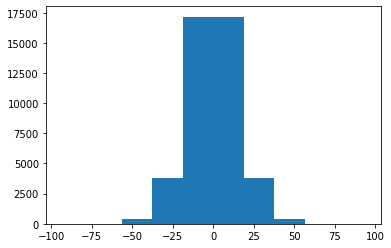

In [26]:
# Create full y value to construct transformer on.  
# We should have both wins and losses setting the mean to 0
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from matplotlib.pyplot import clf
%matplotlib inline


win_loss_y = np.concatenate([ds.y, ds.y*-1], axis=0)
win_loss_x = np.concatenate([ds.X, ds.X], axis=0)
win_loss_ds = NumpyDataset(win_loss_x, win_loss_y)
plt.hist(np.squeeze(win_loss_y))

In [27]:
from ligand_ml.trans.transformers import NormalizationTransformer
transformers = [
    NormalizationTransformer(transform_X=True, dataset=ds),
    NormalizationTransformer(transform_y=True, dataset=win_loss_ds)
]
for trans in transformers:
    ds = trans.transform(ds)

In [28]:
# These normalization params are important if we need to do inference later
# So lets save them

In [29]:
import pickle

In [30]:
pickle.dump(transformers, open('transformers.pkl', 'wb'))

In [31]:
import numpy as np

In [32]:
# Lets do a visual inspection of the features to see if they are relatively normal or if we have to clip

In [33]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from matplotlib.pyplot import clf

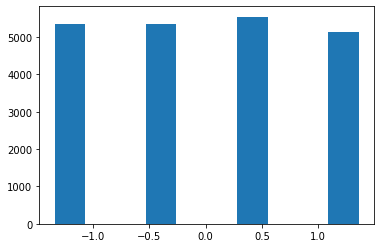

In [35]:
if not os.path.exists('img'):
    os.mkdir('img')
for i in range(ds.X.shape[-1]):
    clf()
    plt.hist(ds.X[:,i])
    savefig('img/%s.png' % i)

(array([1.1464e+04, 6.1560e+03, 2.4440e+03, 9.6100e+02, 2.5900e+02,
        8.0000e+01, 1.8000e+01, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.0662676 , 0.68255632, 1.29884504, 1.91513376, 2.53142248,
        3.14771119, 3.76399991, 4.38028863, 4.99657735, 5.61286607,
        6.22915479]),
 <a list of 10 Patch objects>)

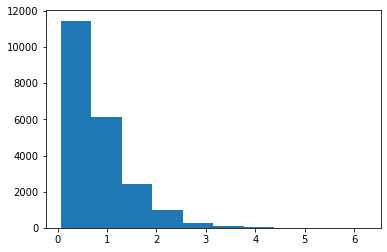

In [36]:
%matplotlib inline
plt.hist(ds.y)

In [37]:
# Seems like clipping is not neccessary yet

In [38]:
# I like 5 folds of data.  Random Split is bad we should do time or team split
# This will lead to overpredicting our real world perf

In [39]:
from ligand_ml.data.splitters import RandomSplitter

splitter = RandomSplitter()
folds = splitter.k_fold_split(ds, 5)

In [40]:
# Lets make sure we save these folds to disk in case we want them later

In [41]:
for i, fold in enumerate(folds):
    train, valid = fold
    train_folder = 'datasets/full_folds/train%s' % i
    DiskDataset.from_numpy(train.X, train.y, train.w, train.ids, data_dir=train_folder)
    
    valid_folder = 'datasets/full_folds/valid%s' % i
    DiskDataset.from_numpy(valid.X, valid.y, valid.w, valid.ids, data_dir=valid_folder)

In [42]:
# We have to augment the data with reverse of each game
def augment_ds(ds):
    X = ds.X
    y = ds.y
    rev_y = ds.y * -1
    
    n_features = X.shape[1] // 2
    t1 = X[:,:n_features]
    t2 = X[:, n_features:]
    rev_x = np.concatenate([t2,t2], axis=1)
    
    full_x = np.concatenate([X,rev_x], axis=0)
    full_y = np.concatenate([y, rev_y], axis=0)
    return NumpyDataset(full_x, full_y)


for i in range(5):
    fname = 'datasets/full_folds/train%s' % i
    ds = DiskDataset(fname)
    ds = augment_ds(ds)
    DiskDataset.from_numpy(ds.X, ds.y, ds.w, ds.ids, data_dir=fname)
    
    fname = 'datasets/full_folds/valid%s' % i
    ds = DiskDataset(fname)
    ds = augment_ds(ds)
    DiskDataset.from_numpy(ds.X, ds.y, ds.w, ds.ids, data_dir=fname)

In [43]:
# Now to train a dummy model to see vaguely how well we are going

In [44]:
train = DiskDataset('datasets/full_folds/train0')
valid = DiskDataset('datasets/full_folds/valid0')

In [45]:
from ligand_ml.models.tensorflow.fcnet import MultitaskRegressor
model = MultitaskRegressor(1, train.X.shape[-1])

In [46]:
train, valid = to_numpy(train), to_numpy(valid)

In [47]:
model.fit(train, nb_epoch=10)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





58.39284708992235

In [48]:
from sklearn.metrics import r2_score
def p_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [49]:
y_pred = model.predict(valid)
print(p_r2(valid.y, np.squeeze(y_pred)))


0.5427715469568997


Text(0, 0.5, 'y_true')

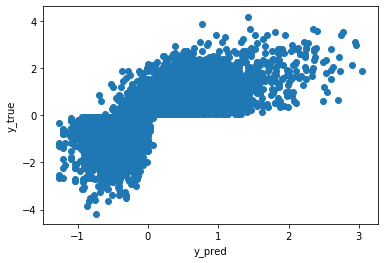

In [50]:
plt.scatter(np.squeeze(y_pred), np.squeeze(valid.y))
plt.xlabel('y_pred')
plt.ylabel('y_true')

In [51]:
# Scatter plot agrees that we have signal.  But the vertical band is still quite wide
# More important than determining score difference is how many games we call correct

In [52]:
def p_correct_cat(y_true, y_pred):
    n_correct = 0
    for yt, yp in zip(y_true, y_pred):
        if yt * yp > 0:
            n_correct += 1
    return n_correct / len(y_true)
        

In [53]:
p_correct_cat(valid.y, np.squeeze(y_pred))

0.9599018003273322

In [54]:
# So our unoptimized Neural Network is doing as well as the benchmark model of picking the higher ranked team
# What happens now that we hyper parameter smash?

In [55]:
# will create a list of hparams and then lay out models in
# models/{key}/{fold_id}
def eval_hprams(model, epochs, train_ds, valid_ds):
    model.fit(train_ds, nb_epoch=epochs)
    model.save()
    y_pred = model.predict(valid_ds)
    return p_r2(valid_ds.y, np.squeeze(y_pred))

def eval_model(hps, key, folds):
    vals = []
    layer_sizes, dropout, epochs = hps[key]['layer_sizes'], hps[key]['dropout'], hps[key]['epochs']
    for i, fold in enumerate(folds):
        train, valid = fold
        model_path = 'models/%s/%s' % (key, i)
        model = MultitaskRegressor(1, n_features=train.X.shape[-1],
                                             layer_sizes=layer_sizes, dropout=dropout,
                                            model_dir=model_path)
        retval = eval_hprams(model, epochs, train, valid)
        vals.append(retval)
    return np.mean(vals), np.std(vals)



    

In [ ]:
folds = [
    (DiskDataset(data_dir='datasets/full_folds/train%s' % x),
     DiskDataset(data_dir='datasets/full_folds/valid%s' % x)
    ) for x in range(5)
]
folds = [(to_numpy(x[0]), to_numpy(x[1])) for x in folds]

In [ ]:
import itertools
hps = {}
layer_sizes = [
    [1000],
    [64, 64],
    [64, 32],
    [64, 32, 16],
    [256, 128]
]

dropouts = [
    0.25, 0.35, 0.5, 0.0
]

epochs = [
    25, 50, 100
]
index = 0
for ls, dr, ep in itertools.product(layer_sizes, dropouts, epochs):
    hps[index] = {
        'layer_sizes': ls,
        'dropout': dr,
        'epochs': ep
    }
    index += 1


In [ ]:
import random
import numpy as np
key_order = list(hps.keys())
random.shuffle(key_order)
print(key_order)

for key in key_order:
    retval = eval_model(hps, key, folds)
    print(key, retval)
    with open('metrics/results.txt', 'a') as fout:
        fout.write("%s,%s,%s\n" % (key, retval[0], retval[1]))

In [ ]:
import json
with open('metrics/hps_0.json', 'w') as fout:
    fout.write(json.dumps(hps))

In [ ]:
# Start here for analysis of best model

In [ ]:
results = [x.strip().split(',') for x in open('metrics/results.txt').readlines()]
results = [[x[0], float(x[1]), float(x[2])] for x in results]
results = sorted(results, key=lambda x: x[1] - 1.96 * x[2], reverse=True)
results[:5]

In [ ]:
import json
hps = json.load(open('metrics/hps_0.json'))
for result in results[:5]:
    print(result[0], hps[result[0]])
best_keys = [x[0] for x in results[:3]]

In [ ]:
import pickle
transformers = pickle.load(open('transformers.pkl', 'rb'))

In [ ]:
d = json.load(open('team_fvs.json'))

In [ ]:
bracket = [
    'Duke',
    'North+Dakota+St.',
    'VCU',
    'UCF',
    'Mississippi+St.',
    'Liberty',
    'Virginia+Tech',
    'Saint+Louis',
    'Maryland',
    'Temple',
    'LSU',
    'Yale',
    'Louisville',
    'Minnesota',
    'Michigan+St.',
    'Bradley',
    
    'Gonzaga',
    'Fairleigh+Dickinson',
    'Syracuse',
    'Baylor',
    'Marquette',
    'Murray+St.',
    'Florida+St.',
    'Vermont',
    'Buffalo',
    'Arizona+St.',
    'Texas+Tech',
    'Northern+Kentucky',
    'Nevada',
    'Florida',
    'Michigan',
    'Montana',
    
    'Virginia',
    'Gardner+Webb',
    'Mississippi',
    'Oklahoma',
    'Wisconsin',
    'Oregon',
    'Kansas+St.',
    'UC+Irvine',
    'Villanova',
    'Saint+Mary%27s',
    'Purdue',
    'Old+Dominion',
    'Cincinnati',
    'Iowa',
    'Tennessee',
    'Colgate',
    
    'North+Carolina',
    'Iona',
    'Utah+St.',
    'Washington',
    'Auburn',
    'New+Mexico+St.',
    'Kansas',
    'Northeastern',
    'Iowa+St.',
    'Ohio+St.',
    'Houston',
    'Georgia+St.',
    'Wofford',
    'Seton+Hall',
    'Kentucky',
    'Abilene+Christian'
]
bracket = ["%s&y=2019" % x for x in bracket]
for team in bracket:
    if team not in d:
        print(team)

In [ ]:
from ligand_ml.models.tensorflow.tensor_graph import TensorGraph
from ligand_ml.models.tensorflow.fcnet import MultitaskRegressor
from ligand_ml.data import DiskDataset, NumpyDataset
from sklearn.metrics import r2_score
import numpy as np
import os

def eval_model(model_paths, ds):
    retval = []
    for model_path in model_paths:
        for i in range(5):
            my_path = os.path.join(model_path, str(i))
            model = TensorGraph.load_from_dir(my_path)
            model_preds = np.array(model.predict(ds))
            model_preds = np.reshape(model_preds, newshape=(-1,1))
            retval.append(model_preds)
    grid = np.concatenate(retval, axis=1)
    return np.mean(grid, axis=1)

def load_fvs():
    with open('team_fvs.json') as fin:
        d = json.loads(fin.read())
        return {k:v[0] for k,v in d.items()}

def load_transformers():
    with open('transformers.pkl', 'rb') as fin:
        return pickle.load(fin)
    
def ds_from_bracket(bracket, transformers, all_teams):
    X = []
    index = []
    for i in range(len(bracket)):
        for j in range(i+1, len(bracket)):
            t1 = bracket[i]
            t2 = bracket[j]
            fv1 = d[t1][0] + d[t2][0]
            fv2 = d[t2][0] + d[t1][0]
            index.append((t1,t2))
            X.append(fv1)
            X.append(fv2)
    X = np.array(X)
    y = np.ones(shape=(len(X),))
    ds = NumpyDataset(X, y)
    for transformer in transformers:
        ds = transformer.transform(ds)
    return ds, index
            
def conjoin_games(l):
    true_scores = []
    for i in range(0, len(l), 2):
        my_score = (l[i] + l[i+1] * -1) / 2
        true_scores.append(my_score)
    return true_scores
    
def play_tourney(bracket, best_models=[36]):
    model_paths = ['models/%s' % i for i in best_models]
    transformers = load_transformers()
    all_teams = load_fvs()
    ds, games = ds_from_bracket(bracket, transformers, all_teams)
    retval = eval_model(model_paths, ds)
    true_scores = conjoin_games(retval)
    return {x:y for x,y in zip(games, true_scores)}
    

In [ ]:
bracket_results = play_tourney(bracket, best_models=[str(x) for x in best_keys])

In [ ]:
def print_pretty(team_names):
    l = [x.split('&y')[0] for x in team_names]
    print(l)

def print_winners(bracket, bracket_results):
    l = list(bracket)
    new_l = []
    while len(l) > 1:
        for i in range(0, len(l), 2):
            key = l[i], l[i+1]
            game_result = bracket_results[key]
            if game_result > 0:
                new_l.append(l[i])
            else:
                new_l.append(l[i+1])
        print("Round of %s" % len(new_l))
        print_pretty(new_l)
        l = new_l
        new_l = []

In [ ]:
print_winners(bracket, bracket_results)